## Flowers dataset
### Multiclass classification (🌼)

In [1]:
import random
import collections
import tensorflow as tf
import urllib
import os

# The flowers dataset has five different label classes.
NUM_CLASSES = 5
FLOWERS_DIR = f'{os.getcwd()}/flower_photos'
TRAIN_FRACTION = 0.8
RANDOM_SEED = 2018


def download_images():
  """If the images aren't already downloaded, save them to FLOWERS_DIR."""
  if not os.path.exists(FLOWERS_DIR):
    DOWNLOAD_URL = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
    print('Downloading flower images from %s...' % DOWNLOAD_URL)
    urllib.request.urlretrieve(DOWNLOAD_URL, 'flower_photos.tgz')
    !tar xfz flower_photos.tgz
  print('Flower photos are located in %s' % FLOWERS_DIR)


def make_train_and_test_sets():
  """Split the data into train and test sets and get the label classes."""
  train_examples, test_examples = [], []
  shuffler = random.Random(RANDOM_SEED)
  is_root = True
  for (dirname, subdirs, filenames) in tf.gfile.Walk(FLOWERS_DIR):
    # The root directory gives us the classes
    if is_root:
      subdirs = sorted(subdirs)
      classes = collections.OrderedDict(enumerate(subdirs))
      label_to_class = dict([(x, i) for i, x in enumerate(subdirs)])
      is_root = False
    # The sub directories give us the image files for training.
    else:
      filenames.sort()
      shuffler.shuffle(filenames)
      full_filenames = [os.path.join(dirname, f) for f in filenames]
      label = dirname.split('/')[-1]
      label_class = label_to_class[label]
      # An example is the image file and it's label class.
      examples = list(zip(full_filenames, [label_class] * len(filenames)))
      num_train = int(len(filenames) * TRAIN_FRACTION)
      train_examples.extend(examples[:num_train])
      test_examples.extend(examples[num_train:])

  shuffler.shuffle(train_examples)
  shuffler.shuffle(test_examples)
  return train_examples, test_examples, classes

In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# Download the images and split the images into train and test sets.
# download_images()
TRAIN_EXAMPLES, TEST_EXAMPLES, CLASSES = make_train_and_test_sets()
NUM_CLASSES = len(CLASSES)

print('\nThe dataset has %d label classes: %s' % (NUM_CLASSES, CLASSES.values()))
print('There are %d training images' % len(TRAIN_EXAMPLES))
print('there are %d test images' % len(TEST_EXAMPLES))

Instructions for updating:
non-resource variables are not supported in the long term

The dataset has 5 label classes: odict_values(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'])
There are 2934 training images
there are 736 test images


### Data Preprocessing

In [3]:
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize, ToPILImage
from torchvision.transforms import CenterCrop
from torch.utils.data import DataLoader


class CustomFlowerDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        # Read image
        image = read_image(img_path)  # This assumes that the image is in PIL format
        if self.transform:
            image = self.transform(image)
        return image, label

# Define transformations
transformations = Compose([
    Resize(256),
    ToPILImage(),
    CenterCrop(224),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create the dataset
train_dataset = CustomFlowerDataset(TRAIN_EXAMPLES, transform=transformations)
test_dataset = CustomFlowerDataset(TEST_EXAMPLES, transform=transformations)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'sunflowers')

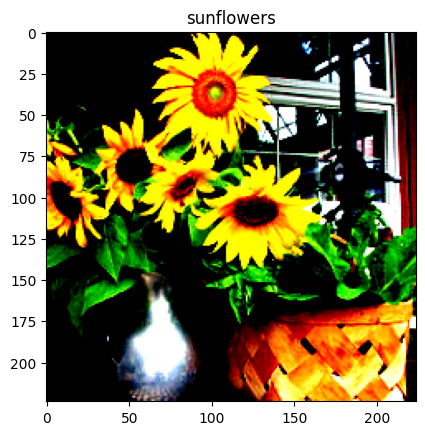

In [4]:
# look at images from train dataset
import matplotlib.pyplot as plt
import numpy as np

# get some random training images
dataiter = iter(train_loader)
images, labels = next(iter(train_dataset))

# show images
plt.imshow(np.transpose(images, (1, 2, 0)))
plt.title(CLASSES[labels])

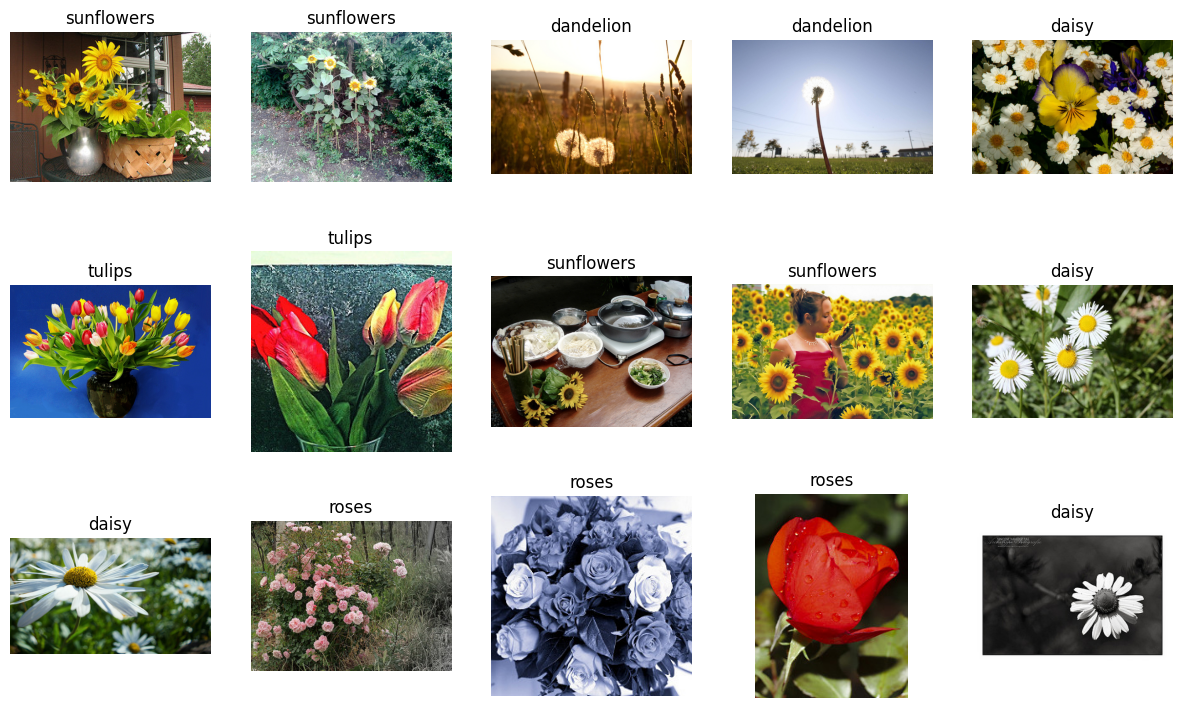

In [5]:
import math
import matplotlib.pyplot as plt
from PIL import Image

def get_class(label):
    """Get the class (string) of given label."""
    return CLASSES[label]

def display_images(images_and_classes, cols=5):
    """Display given images and their labels in a grid."""
    rows = int(math.ceil(len(images_and_classes) / cols))
    _ = plt.figure(figsize=(cols * 3, rows * 3))
    
    for i, (image_path, label) in enumerate(images_and_classes):
        image = Image.open(image_path)  # Open image with PIL
        flower_class = get_class(label)
        
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image)
        plt.title(flower_class)
        plt.axis('off')

NUM_IMAGES = 15  # Set the number of images you want to display
images_and_classes = [(example[0], example[1]) for example in TRAIN_EXAMPLES[:NUM_IMAGES]]

display_images(images_and_classes)
plt.show()

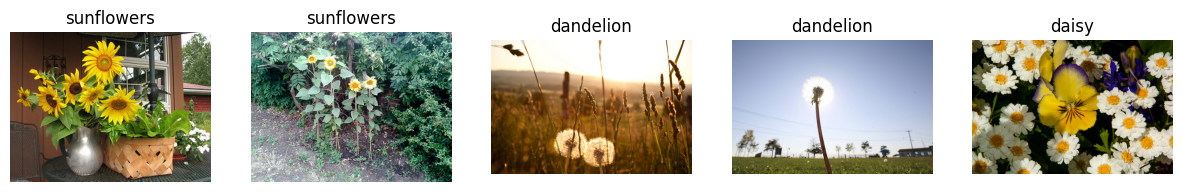

In [6]:
NUM_IMAGES = 5  # Set the number of images you want to display
images_and_classes = [(example[0], example[1]) for example in TRAIN_EXAMPLES[:NUM_IMAGES]]

display_images(images_and_classes)
plt.show()

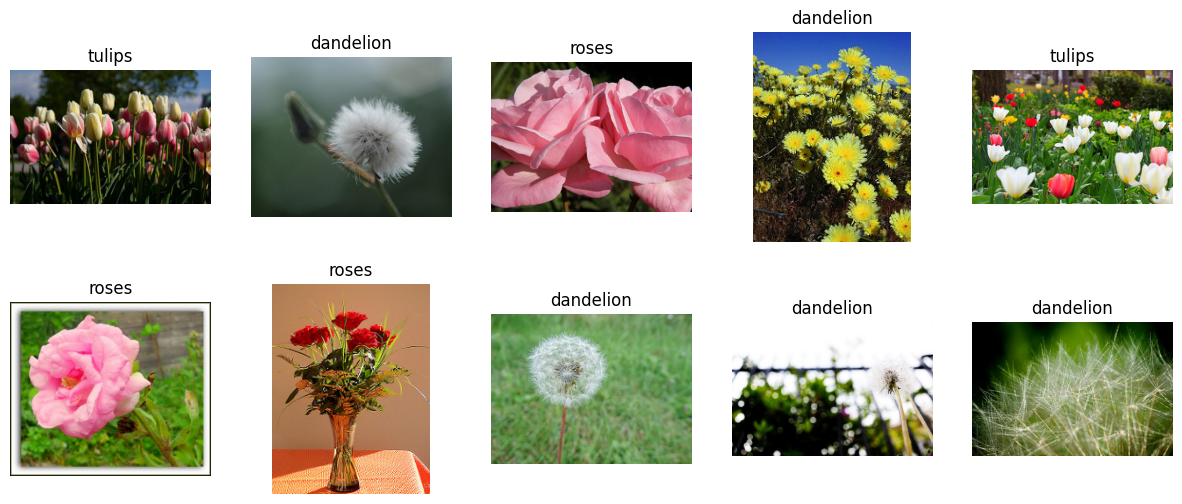

In [7]:
import random

NUM_IMAGES = 10  # Set the number of images you want to randomly sample

# Randomly sample images and their labels
random_samples = random.sample(TRAIN_EXAMPLES, NUM_IMAGES)
images_and_classes = [(example[0], example[1]) for example in random_samples]

display_images(images_and_classes)
plt.show()


### Multiclass problem

In [8]:
import torch

class_names = list(CLASSES.values())

def print_label_distribution(dataloader, class_names):
    # Initialize a zero-filled tensor to store label counts, the size is the number of classes
    label_counts = torch.zeros(len(class_names), dtype=torch.int64)
    
    # Iterate over the DataLoader to accumulate label counts
    for _, labels in dataloader:
        labels = labels.numpy()  # Convert labels to a numpy array
        counts = np.bincount(labels, minlength=len(class_names))
        label_counts += torch.tensor(counts, dtype=torch.int64)
    
    # Print the label counts
    for label_index, count in enumerate(label_counts):
        print(f"Label {class_names[label_index]}: {count} samples")

# Example usage
print("Training set label distribution:")
print_label_distribution(train_loader, class_names)

print("\nTest set label distribution:")
print_label_distribution(test_loader, class_names)

Training set label distribution:
Label daisy: 506 samples
Label dandelion: 718 samples
Label roses: 512 samples
Label sunflowers: 559 samples
Label tulips: 639 samples

Test set label distribution:
Label daisy: 127 samples
Label dandelion: 180 samples
Label roses: 129 samples
Label sunflowers: 140 samples
Label tulips: 160 samples


### Feedforward Neural Network

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

losses = []

class MulticlassClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MulticlassClassifier, self).__init__()
        self.layer1 = nn.Linear(input_size, 256)
        self.batch_norm1 = nn.BatchNorm1d(256)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(256, 128)
        self.batch_norm2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.layer3 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.batch_norm1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.batch_norm2(x)
        x = self.relu2(x)
        x = self.dropout(x)
        x = self.layer3(x)  # Use separate output neuron for each class
        return x

# Define correct size for the input
input_size = 224 * 224 * 3
model = MulticlassClassifier(input_size, NUM_CLASSES).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

num_epochs = 10

time_start = time.time()

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Flatten inputs if necessary
        inputs = inputs.view(inputs.size(0), -1)  # Flatten the images

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        losses.append(loss.item())

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
    
time_end = time.time()
print(f"Time: {time_end - time_start:.2f}s")

In [17]:
val_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

def evaluate_model(model, dataloader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():  # Disable gradient tracking
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # No need to reshape inputs for models like ResNet
            outputs = model(inputs.view(inputs.size(0), -1))  # Flatten the images
            
            # Compute the loss
            loss = criterion(outputs, labels)  # Use outputs directly
            
            total_loss += loss.item() * inputs.size(0)
            
            # Calculate the number of correct predictions
            _, predicted_labels = torch.max(outputs, 1)  # Get the index of the max log-probability
            
            correct_predictions += (predicted_labels == labels).sum().item()
            total_samples += labels.size(0)
    
    # Calculate average loss and accuracy
    average_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples
        
    return average_loss, accuracy

# Assuming `criterion` is now nn.CrossEntropyLoss()
test_loss, test_accuracy = evaluate_model(model, val_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2%}')

Test Loss: 1.2222, Test Accuracy: 47.42%


In [ ]:
PATH = 'flowers/model_flowers_multiclass.pth'
torch.save(model.state_dict(), PATH)

### ResNet18

In [38]:
import torch.optim as optim
from torchvision import models
import torch.nn as nn
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load pretrained ResNet18 model
model = models.resnet18(weights='IMAGENET1K_V1')

# Freeze all layers in the ResNet model
for param in model.parameters():
    param.requires_grad = False

# Replace the last fully connected layer with a new one
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, NUM_CLASSES)

# Move the model to the device
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

Epoch 1/10, Loss: 0.6081
Epoch 2/10, Loss: 0.3694
Epoch 3/10, Loss: 0.2837
Epoch 4/10, Loss: 0.2840
Epoch 5/10, Loss: 0.2401
Epoch 6/10, Loss: 0.2930
Epoch 7/10, Loss: 0.2579
Epoch 8/10, Loss: 0.2269
Epoch 9/10, Loss: 0.2171
Epoch 10/10, Loss: 0.2501


In [39]:
from torch.utils.data import DataLoader

binary_val_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

def evaluate_model(model, dataloader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():  # Disable gradient tracking
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
                        
            # Ensure inputs have the correct shape expected by the model
            # inputs = inputs.view(inputs.size(0), -1)
            outputs = model(inputs)
                        
            # Compute the loss
            loss = criterion(outputs, labels)  # Use outputs directly
            
            total_loss += loss.item() * inputs.size(0)
            
            # Calculate the number of correct predictions
            _, predicted_labels = torch.max(outputs, 1)  # Get the index of the max log-probability
            
            correct_predictions += (predicted_labels == labels).sum().item()
            total_samples += labels.size(0)
    
    # Calculate average loss and accuracy
    average_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples
        
    return average_loss, accuracy

test_loss, test_accuracy = evaluate_model(model, binary_val_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.0%}')

Test Loss: 0.3106, Test Accuracy: 91%


### Serialize and load

In [40]:
PATH = 'flowers/model_resnet_flowers_multiclass.pth'

torch.save(model.state_dict(), PATH)

In [41]:
import torch
import torchvision.models as models

# Define the same model architecture as was used during training
# For example, if you used a pre-trained ResNet model and modified the final layer:
model = models.resnet18(weights='IMAGENET1K_V1') # models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, NUM_CLASSES)

# Load the saved state dictionary into this model architecture
model.load_state_dict(torch.load(PATH))

# Ensure to call model.to(device) if you are using GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

### Visualization

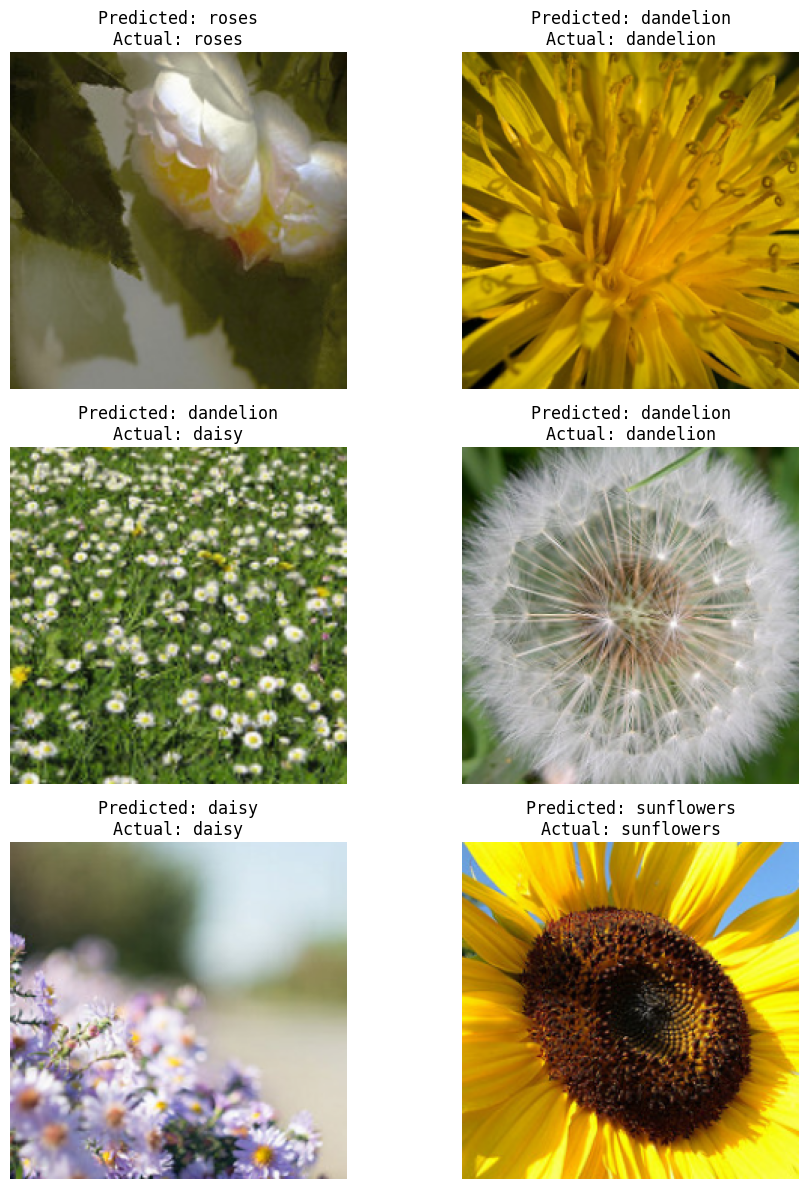

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader

# set font to monospace
plt.rcParams['font.family'] = 'monospace'

# Assuming 'class_names' is updated to reflect all classes in the multiclass problem
class_names = list(CLASSES.values())

def visualize_model(model, dataloader, class_names, num_images=6):
    # sourcery skip: extract-duplicate-method
    was_training = model.training
    model.eval()
    images_so_far = 0
    
    plt.figure(figsize=(10, 12))  # Adjust the figure size to make the images clearer

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)  # Correctly use the model without flattening inputs
            _, preds = torch.max(outputs, 1)  # This is the correct way to get predictions for multiclass
            
            for j in range(inputs.size(0)):
                if images_so_far == num_images:
                    break  # Exit early if we've reached the required number of images
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]}\nActual: {class_names[labels[j]]}', fontsize=12)
                
                # Assuming the input tensor is normalized, you might need to denormalize it to display correctly
                # Example normalization reversal, adjust mean and std as per your normalization
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                image = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                image = std * image + mean
                image = np.clip(image, 0, 1)
                plt.imshow(image)
                
                if images_so_far == num_images:
                    model.train(mode=was_training)  # Reset model to its previous state
                    plt.tight_layout()  # Adjust layout to prevent overlapping titles
                    plt.show()
                    return
        model.train(mode=was_training)
        plt.tight_layout()  # Adjust layout to prevent overlapping titles
        plt.show()

# Assuming 'test_dataset' and 'device' are already defined
test_loader = DataLoader(test_dataset, batch_size=12, shuffle=False)

# Call the function with the correct class names for your multiclass problem
visualize_model(model, test_loader, class_names, num_images=6)

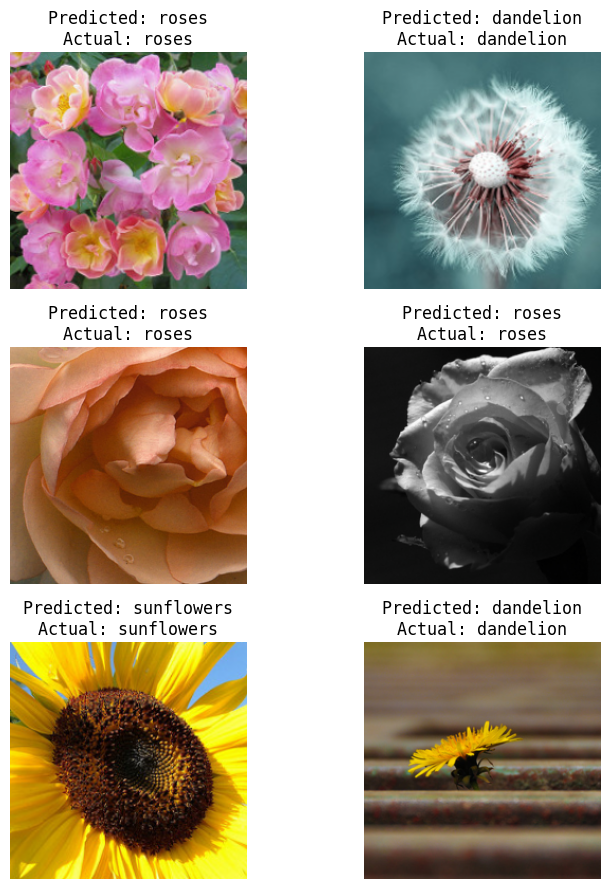

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader

class_names = list(CLASSES.values())

def visualize_model(model, dataloader, class_names, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    rows = num_images // 2 + num_images % 2

    plt.figure(figsize=(8, rows * 3))

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                if images_so_far == num_images:
                    break
                images_so_far += 1
                plt.subplot(rows, 2, images_so_far)
                plt.axis('off')
                plt.title(f"Predicted: {class_names[preds[j]]}\nActual: {class_names[labels[j]]}", fontsize=12)
                
                image = inputs.cpu().data[j].permute(1, 2, 0).numpy()
                # Assuming normalization was applied, adjust mean and std as per your normalization
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                image = std * image + mean  # Denormalize
                image = np.clip(image, 0, 1)  # Clip to ensure valid image
                plt.imshow(image)

        plt.tight_layout()
        plt.show()

    model.train(mode=was_training)
    
test_loader = DataLoader(test_dataset, batch_size=12, shuffle=True)
visualize_model(model, test_loader, class_names, num_images=6)

### Integrated Gradients

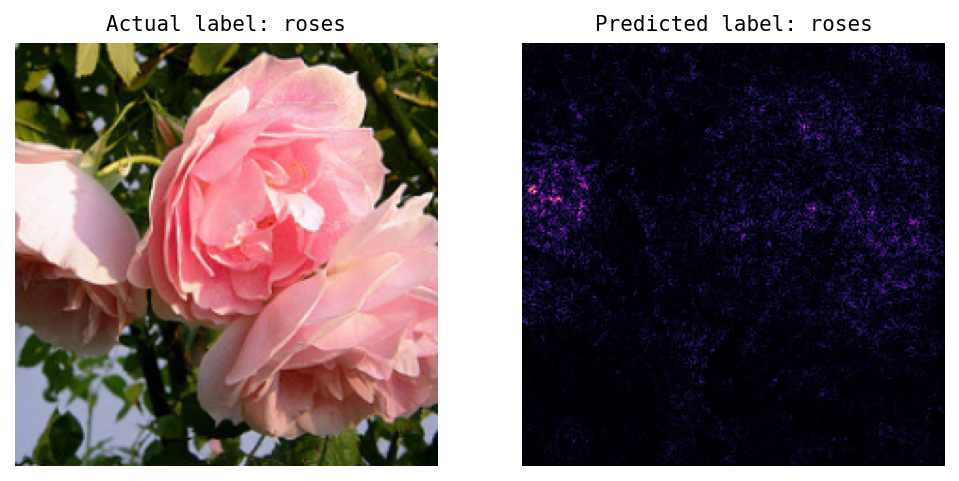

In [56]:
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_attributions(model, dataloader, device, class_names):
    model.eval()
    integrated_gradients = IntegratedGradients(model)

    # Get a single batch from the dataloader
    inputs, labels = next(iter(dataloader))
    inputs, labels = inputs.to(device), labels.to(device)

    # Calculate attributions using the actual labels as targets
    attributions = integrated_gradients.attribute(inputs, target=labels, n_steps=100)

    # Mean of the absolute values of attributions across the color channels for visualization
    attribution_np = np.mean(np.abs(attributions[0].cpu().data.numpy()), axis=0)

    _, predicted_labels = torch.max(model(inputs), 1)  # Get predictions from the model directly
    
    # Visualize the first image, its attributions, actual label, and predicted label
    _, axs = plt.subplots(1, 2, figsize=(8, 5), dpi=150)
    image_np = inputs[0].cpu().data.numpy().transpose((1, 2, 0))
    
    # Normalize the image if necessary (adjust mean and std as per your normalization)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_np = std * image_np + mean  # Denormalize
    image_np = np.clip(image_np, 0, 1)  # Clip to ensure valid image range
    
    axs[0].imshow(image_np)
    axs[0].axis('off')
    axs[0].set_title(f"Actual label: {class_names[labels[0].item()]}", fontsize=10)

    axs[1].imshow(attribution_np, cmap='magma', alpha=1.0)
    axs[1].axis('off')
    axs[1].set_title(f"Predicted label: {class_names[predicted_labels[0].item()]}", fontsize=10)

    plt.show()

visualize_attributions(model, test_loader, device, class_names)

### Conformal Prediction

In [59]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()

# Assuming cal_loader is your DataLoader for the calibration set
conformity_scores = []

cal_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)

with torch.no_grad():
    for X_cal, y_cal in cal_loader:
        X_cal, y_cal = X_cal.to(device), y_cal.to(device)
        logits_cal = model(X_cal)
        probs_cal = F.softmax(logits_cal, dim=1)

        for idx in range(X_cal.size(0)):
            correct_class_prob = probs_cal[idx, y_cal[idx]]
            probs_temp = probs_cal[idx].clone()
            probs_temp[y_cal[idx]] = 0
            max_incorrect_class_prob = torch.max(probs_temp)
            margin = correct_class_prob - max_incorrect_class_prob
            conformity_scores.append(-margin.cpu().numpy())  # Store negative margins as conformity scores

alpha = 0.05
threshold = np.quantile(conformity_scores, 1 - alpha)

# Evaluate a new instance
X_new, _ = next(iter(test_loader))  # Assuming test_loader is for new instances, ignore labels
X_new = X_new.to(device)

with torch.no_grad():
    logits_new = model(X_new)
    probs_new = F.softmax(logits_new, dim=1).squeeze()

    # Calculate the margins for all possible classes for the new instance
    margins_new = []
    for class_index in range(probs_new.size(0)):
        correct_class_prob_new = probs_new[class_index]
        probs_temp = probs_new.clone()
        probs_temp[class_index] = 0
        max_incorrect_class_prob_new = torch.max(probs_temp)
        margin_new = correct_class_prob_new - max_incorrect_class_prob_new
        margins_new.append(-margin_new.cpu().numpy())  # Store negative margins for the new instance

    # Identify classes in the conformal prediction set
    conformal_prediction_set = [class_index for class_index, margin in enumerate(margins_new) if margin >= threshold]

    # Map class indices to class names if necessary
    conformal_prediction_set_names = [CLASSES[i] for i in conformal_prediction_set]

print(f"Conformal prediction set for the new instance: {conformal_prediction_set_names}")

Conformal prediction set for the new instance: ['daisy', 'dandelion', 'sunflowers', 'tulips']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


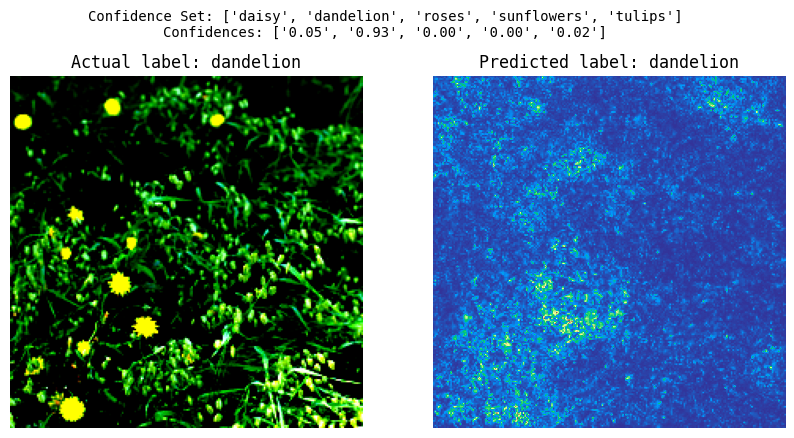

In [111]:
import numpy as np
import torch
import torch.nn.functional as F
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt

# Set font style
plt.rcParams['font.family'] = 'monospace'

# Define device and class names
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_names = list(CLASSES.values())  # Make sure this matches your classes

def visualize_attributions_with_confidence(model, dataloader, device, class_names, alpha=0.05):
    model.eval()
    integrated_gradients = IntegratedGradients(model)

    # Get a batch for calibration (assumed to have labels)
    X_cal, y_cal = next(iter(dataloader))
    X_cal, y_cal = X_cal.to(device), y_cal.to(device)

    # Get another batch for the new instance demonstration (assumed to have labels)
    X_new, y_new = next(iter(dataloader))
    X_new, y_new = X_new.to(device), y_new.to(device)

    # Calculate conformity scores based on the calibration set
    conformity_scores = []
    with torch.no_grad():
        logits_cal = model(X_cal)
        probs_cal = F.softmax(logits_cal, dim=1)
        for idx in range(X_cal.size(0)):
            correct_prob = probs_cal[idx, y_cal[idx]]
            max_incorrect_prob = torch.max(torch.cat((probs_cal[idx, :y_cal[idx]], probs_cal[idx, y_cal[idx]+1:])))
            margin = correct_prob - max_incorrect_prob
            conformity_scores.append(-margin.item())  # Negative for conformity

    threshold = np.quantile(conformity_scores, 1 - alpha)

    # Evaluate the new instance
    with torch.no_grad():
        logits_new = model(X_new[:1])
        probs_new = F.softmax(logits_new, dim=1).squeeze()

    # Calculate attributions for the new image
    attributions = integrated_gradients.attribute(X_new[:1], target=y_new[:1], n_steps=1_500)
    attribution_np = np.mean(np.abs(attributions[0].cpu().data.numpy()), axis=0)
    image_np = X_new[0].cpu().data.numpy().transpose((1, 2, 0))

    # Determine predicted class and confidence set
    predicted_class = torch.argmax(probs_new).item()
    confidence_set = [i for i, prob in enumerate(probs_new) if -np.log(prob.item()) >= threshold]
    confidence_set_names = [class_names[i] for i in confidence_set if i < len(class_names)]

    # Visualization
    _, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(image_np)
    axs[0].axis('off')
    axs[0].set_title(f"Actual label: {class_names[y_new[0].item()]}")

    axs[1].imshow(attribution_np, cmap='terrain', alpha=1.0)
    axs[1].axis('off')
    axs[1].set_title(f"Predicted label: {class_names[predicted_class]}")

    # Display confidence set and confidences
    confidences_formatted = [f"{prob:.2f}" for prob in probs_new[confidence_set].cpu().numpy()]
    plt.suptitle(f"Confidence Set: {confidence_set_names}\nConfidences: {confidences_formatted}", fontsize=10)
    plt.savefig('flowers/snapshots/confidence_set_5.png', dpi=150)
    plt.show()

# Run the visualization function
visualize_attributions_with_confidence(model, test_loader, device, class_names)